In [1]:
!pip install graphviz sqlalchemy



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install networkx matplotlib

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install sqlalchemy networkx matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import subprocess
from pathlib import Path

# Sesuaikan kalau DB / user / port beda
PG_HOST = "127.0.0.1"
PG_PORT = "5433"
PG_DB   = "latihan"
PG_USER = "user"

sql_dir = Path("sql")

scripts = [
    "01_public_dxb_ops.sql",
    "02_dxb_ops_flight_stability.sql",
    "03_eng_proc_lcc.sql",
]

for script in scripts:
    path = sql_dir / script
    print(f"Running {path} ...")
    subprocess.run(
        [
            "psql",
            "-h", PG_HOST,
            "-p", PG_PORT,
            "-U", PG_USER,
            "-d", PG_DB,
            "-f", str(path),
        ],
        check=True
    )

print("All scripts executed.")


Running sql/01_public_dxb_ops.sql ...
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
DROP TABLE
CREATE TABLE
INSERT 0 6
CREATE TABLE
INSERT 0 3
CREATE TABLE
INSERT 0 6
CREATE TABLE
INSERT 0 27
CREATE TABLE
INSERT 0 5
CREATE TABLE
INSERT 0 9
CREATE TABLE
INSERT 0 2
CREATE TABLE
INSERT 0 6
CREATE TABLE
INSERT 0 6
CREATE TABLE
INSERT 0 6
Running sql/02_dxb_ops_flight_stability.sql ...
CREATE SCHEMA
DROP TABLE
DROP TABLE
DROP TABLE
CREATE TABLE
CREATE TABLE
CREATE INDEX
CREATE FUNCTION
DROP TRIGGER
CREATE TRIGGER
INSERT 0 6
UPDATE 1
UPDATE 1
 flight_id |  op_date   | airline_code | etd_change_count |  total_etd_shift_min   
-----------+------------+--------------+------------------+------------------------
         1 | 2025-11-10 | EK           |                0 | 0.00000000000000000000
         2 | 2025-11-10 | EK           |                0 | 0.00000000000000000000
         3 | 2025-11-10 | EK           |                0 | 0.00000000

psql:sql/02_dxb_ops_flight_stability.sql:10: NOTICE:  schema "dxb_ops" already exists, skipping
psql:sql/02_dxb_ops_flight_stability.sql:122: NOTICE:  trigger "trg_flights_live_audit" for relation "dxb_ops.flights_live" does not exist, skipping
psql:sql/03_eng_proc_lcc.sql:10: NOTICE:  schema "eng_proc" already exists, skipping
psql:sql/03_eng_proc_lcc.sql:14: ERROR:  cannot drop table eng_proc.lcc_scenarios because other objects depend on it
DETAIL:  materialized view eng_proc.lcc_npv_mv depends on table eng_proc.lcc_scenarios
HINT:  Use DROP ... CASCADE to drop the dependent objects too.
psql:sql/03_eng_proc_lcc.sql:21: ERROR:  cannot drop table eng_proc.parts because other objects depend on it
DETAIL:  constraint lcc_scenarios_part_id_fkey on table eng_proc.lcc_scenarios depends on table eng_proc.parts
materialized view eng_proc.lcc_npv_mv depends on table eng_proc.parts
HINT:  Use DROP ... CASCADE to drop the dependent objects too.
psql:sql/03_eng_proc_lcc.sql:22: ERROR:  cannot dr

In [5]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("postgresql://user@127.0.0.1:5433/latihan")  # tambah :password@ kalau perlu

query = """
SELECT
    airline_code,
    COUNT(*) AS flights,
    AVG(etd_change_count) AS avg_etd_changes,
    AVG(total_etd_shift_min) AS avg_shift_min,
    AVG(stability_score) AS avg_stability_score
FROM dxb_ops.fact_flight_stability
GROUP BY airline_code
ORDER BY avg_stability_score ASC;
"""

df = pd.read_sql(query, engine)
df


,airline_code,flights,avg_etd_changes,avg_shift_min,avg_stability_score
0,BA,1,2.0,30.0,65.0
1,QR,1,0.0,0.0,100.0
2,SQ,1,0.0,0.0,100.0
3,EK,3,0.0,0.0,100.0


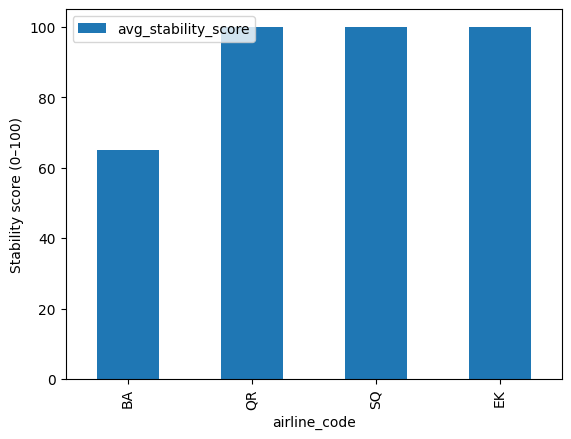

In [6]:
import matplotlib.pyplot as plt

df.plot.bar(x="airline_code", y="avg_stability_score")
plt.ylabel("Stability score (0–100)")
plt.show()


In [7]:
lcc_query = """
WITH cashflows AS (
    SELECT s.scenario_name,
           p.part_number,
           sup.supplier_name,
           n.npv_total_cost
    FROM eng_proc.lcc_scenarios s
    JOIN eng_proc.parts p      ON p.part_id = s.part_id
    JOIN eng_proc.suppliers sup ON sup.supplier_id = s.supplier_id
    JOIN eng_proc.lcc_npv n   ON n.scenario_id = s.scenario_id
)
SELECT * FROM cashflows
ORDER BY npv_total_cost;
"""

lcc_df = pd.read_sql(lcc_query, engine)
lcc_df


,scenario_name,part_number,supplier_name,npv_total_cost
0,OEM_A baseline,BRAKE-A380,OEM Aero Systems,3.467392e+06
1,MRO_X aggressive,BRAKE-A380,MRO X Dubai,3.936281e+06


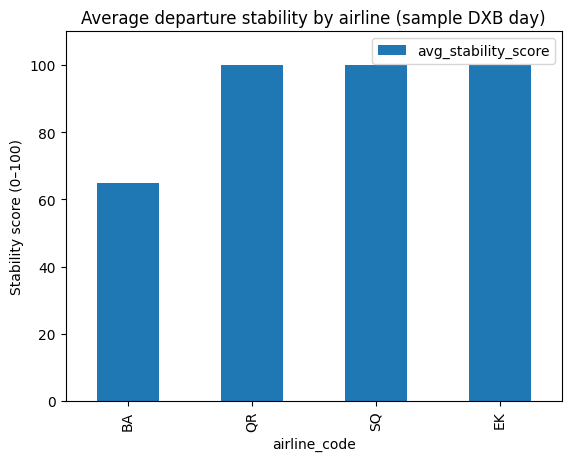

In [8]:
import matplotlib.pyplot as plt

# df sudah berisi airline_code + avg_stability_score
df.plot.bar(x="airline_code", y="avg_stability_score")
plt.ylabel("Stability score (0–100)")
plt.title("Average departure stability by airline (sample DXB day)")
plt.ylim(0, 110)
plt.show()


In [9]:
import sqlalchemy as sa
import pandas as pd

# SESUAIKAN kalau user/port/db beda
PG_USER = "user"
PG_HOST = "127.0.0.1"
PG_PORT = "5433"
PG_DB   = "latihan"

engine = sa.create_engine(f"postgresql+psycopg2://{PG_USER}@{PG_HOST}:{PG_PORT}/{PG_DB}")

def run_health_checks(engine):
    checks = []

    # 1) Jumlah flight harus 6 (sesuai seed)
    df_flights = pd.read_sql("SELECT COUNT(*) AS n FROM flights;", engine)
    n_flights = int(df_flights["n"].iloc[0])
    checks.append({
        "check_name": "flight_count_is_6",
        "expected": 6,
        "actual": n_flights,
        "ok": (n_flights == 6),
    })

    # 2) BA108 stability_score harus 65
    df_ba = pd.read_sql("""
        SELECT stability_score
        FROM dxb_ops.fact_flight_stability
        WHERE flight_number = 'BA108';
    """, engine)
    if not df_ba.empty:
        ba_score = float(df_ba["stability_score"].iloc[0])
        checks.append({
            "check_name": "BA108_stability_65",
            "expected": 65.0,
            "actual": ba_score,
            "ok": abs(ba_score - 65.0) < 1e-6,
        })
    else:
        checks.append({
            "check_name": "BA108_stability_65",
            "expected": 65.0,
            "actual": "NOT FOUND",
            "ok": False,
        })

    # 3) LCC scenario harus tepat 2 (OEM vs MRO)
    df_scen = pd.read_sql("SELECT COUNT(*) AS n FROM eng_proc.lcc_scenarios;", engine)
    n_scen = int(df_scen["n"].iloc[0])
    checks.append({
        "check_name": "lcc_scenarios_2",
        "expected": 2,
        "actual": n_scen,
        "ok": (n_scen == 2),
    })

    return pd.DataFrame(checks)

dq = run_health_checks(engine)
dq


,check_name,expected,actual,ok
0,flight_count_is_6,6.0,6.0,True
1,BA108_stability_65,65.0,65.0,True
2,lcc_scenarios_2,2.0,2.0,True


In [10]:
import numpy as np
import pandas as pd

def simulate_lcc(
    scenario_name,
    annual_fh,
    fh_per_failure,
    base_unit_price,
    annual_esc_pct,
    interrupt_cost_per_event,
    horizon_years,
    discount_rate
):
    years = np.arange(1, horizon_years + 1)

    failures_per_year = annual_fh / fh_per_failure
    unit_price_year = base_unit_price * (1 + annual_esc_pct/100.0)**(years - 1)

    material_cost = failures_per_year * unit_price_year
    interrupt_cost = failures_per_year * interrupt_cost_per_event
    total_cost = material_cost + interrupt_cost

    discount_factor = 1 / (1 + discount_rate)**years
    discounted_total_cost = total_cost * discount_factor
    npv_total_cost = discounted_total_cost.sum()

    df = pd.DataFrame({
        "scenario_name": scenario_name,
        "year": years,
        "failures_per_year": failures_per_year,
        "unit_price_year": unit_price_year,
        "material_cost": material_cost,
        "interrupt_cost": interrupt_cost,
        "total_cost": total_cost,
        "discount_factor": discount_factor,
        "discounted_total_cost": discounted_total_cost,
    })
    return npv_total_cost, df


In [11]:
# OEM_A baseline
oem_npv, oem_cf = simulate_lcc(
    scenario_name="OEM_A baseline",
    annual_fh=20000,
    fh_per_failure=6000,
    base_unit_price=120000,
    annual_esc_pct=3,
    interrupt_cost_per_event=20000,
    horizon_years=10,
    discount_rate=0.08,
)

# MRO_X aggressive
mro_npv, mro_cf = simulate_lcc(
    scenario_name="MRO_X aggressive",
    annual_fh=20000,
    fh_per_failure=4000,
    base_unit_price=90000,
    annual_esc_pct=2,
    interrupt_cost_per_event=20000,
    horizon_years=10,
    discount_rate=0.08,
)

oem_npv, mro_npv


(np.float64(3467392.236389078), np.float64(3936281.059745605))

In [12]:
cf_all = pd.concat([oem_cf, mro_cf], ignore_index=True)
cf_all.head()


,scenario_name,year,failures_per_year,unit_price_year,material_cost,interrupt_cost,total_cost,discount_factor,discounted_total_cost
0,OEM_A baseline,1,3.333333,120000.0000,400000.000,66666.666667,466666.666667,0.925926,432098.765432
1,OEM_A baseline,2,3.333333,123600.0000,412000.000,66666.666667,478666.666667,0.857339,410379.515318
2,OEM_A baseline,3,3.333333,127308.0000,424360.000,66666.666667,491026.666667,0.793832,389792.799201
3,OEM_A baseline,4,3.333333,131127.2400,437090.800,66666.666667,503757.466667,0.735030,370276.776569
4,OEM_A baseline,5,3.333333,135061.0572,450203.524,66666.666667,516870.190667,0.680583,351773.166815


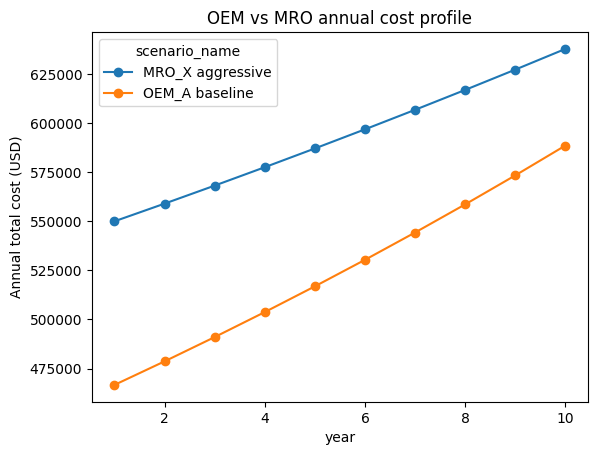

OEM NPV 10y :  3467392.24
MRO NPV 10y :  3936281.06
Delta (MRO - OEM):  468888.82


In [13]:
import matplotlib.pyplot as plt

pivot_cost = cf_all.pivot(index="year", columns="scenario_name", values="total_cost")

pivot_cost.plot(marker="o")
plt.ylabel("Annual total cost (USD)")
plt.title("OEM vs MRO annual cost profile")
plt.show()

print("OEM NPV 10y : ", round(oem_npv, 2))
print("MRO NPV 10y : ", round(mro_npv, 2))
print("Delta (MRO - OEM): ", round(mro_npv - oem_npv, 2))


In [14]:
stability_df = pd.read_sql("""
    SELECT
        airline_code,
        COUNT(*)                    AS flights,
        AVG(etd_change_count)       AS avg_etd_changes,
        AVG(total_etd_shift_min)    AS avg_shift_min,
        AVG(stability_score)        AS avg_stability_score
    FROM dxb_ops.fact_flight_stability
    GROUP BY airline_code
    ORDER BY avg_stability_score ASC;
""", engine)

stability_df


,airline_code,flights,avg_etd_changes,avg_shift_min,avg_stability_score
0,BA,1,2.0,30.0,65.0
1,QR,1,0.0,0.0,100.0
2,SQ,1,0.0,0.0,100.0
3,EK,3,0.0,0.0,100.0


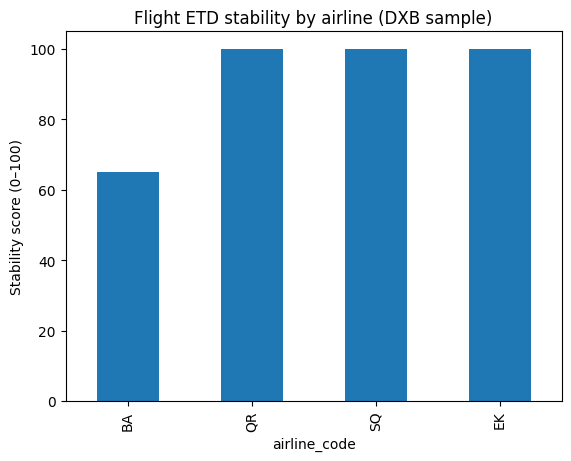

In [15]:
stability_df.plot(
    kind="bar",
    x="airline_code",
    y="avg_stability_score",
    legend=False
)
plt.ylabel("Stability score (0–100)")
plt.title("Flight ETD stability by airline (DXB sample)")
plt.ylim(0, 105)
plt.show()


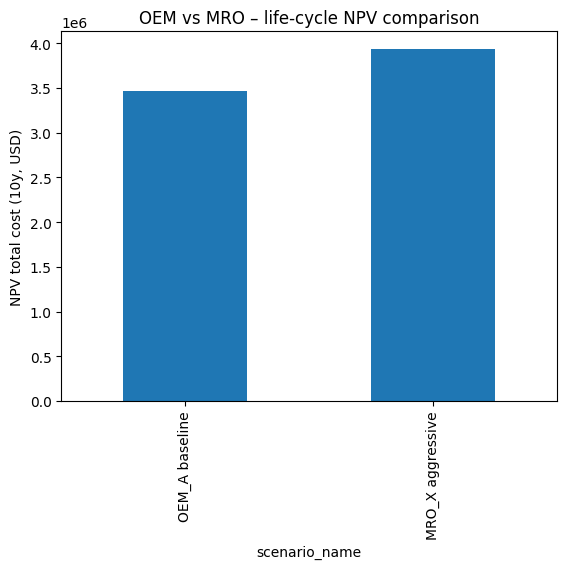

In [16]:
lcc_df = pd.read_sql("""
WITH cashflows AS (
    SELECT
        s.scenario_name,
        year,
        (s.annual_fh / s.fh_per_failure) AS failures_per_year,
        s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS unit_price_year,
        (s.annual_fh / s.fh_per_failure)
            * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS material_cost,
        (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS interrupt_cost,
        (s.annual_fh / s.fh_per_failure)
            * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1)
          + (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS total_cost
    FROM eng_proc.lcc_scenarios s
    CROSS JOIN LATERAL generate_series(1, s.horizon_years) AS year
),
npv AS (
    SELECT
        s.scenario_name,
        SUM(c.total_cost / POWER(1 + s.discount_rate, c.year)) AS npv_total_cost
    FROM cashflows c
    JOIN eng_proc.lcc_scenarios s USING (scenario_name)
    GROUP BY s.scenario_name
)
SELECT * FROM npv
ORDER BY npv_total_cost;
""", engine)

lcc_df

lcc_df.plot(
    kind="bar",
    x="scenario_name",
    y="npv_total_cost",
    legend=False
)
plt.ylabel("NPV total cost (10y, USD)")
plt.title("OEM vs MRO – life-cycle NPV comparison")
plt.show()


In [17]:
import sqlalchemy as sa

def explain_analyze(sql: str):
    """
    Jalankan EXPLAIN ANALYZE untuk query SQL dan print hasilnya baris-per-baris.
    """
    wrapped = f"EXPLAIN (ANALYZE, BUFFERS, FORMAT TEXT)\n{sql}"
    with engine.connect() as conn:
        rows = conn.execute(sa.text(wrapped)).fetchall()
    for r in rows:
        # biasanya hasil ada di kolom pertama
        print(r[0])


In [18]:
stability_sql = """
SELECT
    airline_code,
    COUNT(*)                    AS flights,
    AVG(etd_change_count)       AS avg_etd_changes,
    AVG(total_etd_shift_min)    AS avg_shift_min,
    AVG(stability_score)        AS avg_stability_score
FROM dxb_ops.fact_flight_stability
GROUP BY airline_code
ORDER BY avg_stability_score ASC;
"""

explain_analyze(stability_sql)


Sort  (cost=32.39..32.89 rows=200 width=128) (actual time=0.053..0.054 rows=4 loops=1)
  Sort Key: (avg(stability_score))
  Sort Method: quicksort  Memory: 25kB
  Buffers: shared hit=1
  ->  HashAggregate  (cost=21.25..24.75 rows=200 width=128) (actual time=0.036..0.044 rows=4 loops=1)
        Group Key: airline_code
        Batches: 1  Memory Usage: 40kB
        Buffers: shared hit=1
        ->  Seq Scan on fact_flight_stability  (cost=0.00..15.00 rows=500 width=92) (actual time=0.012..0.013 rows=6 loops=1)
              Buffers: shared hit=1
Planning Time: 0.112 ms
Execution Time: 0.117 ms


In [19]:
staffing_gap_sql = """
WITH demand AS (
    SELECT
        DATE(start_time) AS ops_date,
        DATE_TRUNC('hour', start_time) AS hour_slot,
        role,
        SUM(required_staff) AS total_required_staff
    FROM public.flight_task_requirements
    GROUP BY DATE(start_time), DATE_TRUNC('hour', start_time), role
),
supply AS (
    SELECT
        DATE(shift_start) AS ops_date,
        DATE_TRUNC('hour', shift_start) AS hour_slot,
        role,
        COUNT(DISTINCT staff_id) AS available_staff
    FROM public.rosters
    GROUP BY DATE(shift_start), DATE_TRUNC('hour', shift_start), role
)
SELECT
    d.ops_date,
    d.hour_slot,
    d.role,
    d.total_required_staff,
    COALESCE(s.available_staff, 0) AS available_staff,
    COALESCE(s.available_staff, 0) - d.total_required_staff AS staffing_gap
FROM demand d
LEFT JOIN supply s
  ON d.ops_date  = s.ops_date
 AND d.hour_slot = s.hour_slot
 AND d.role      = s.role
ORDER BY d.ops_date, d.hour_slot, d.role;
"""

explain_analyze(staffing_gap_sql)


Merge Left Join  (cost=51.89..63.53 rows=200 width=114) (actual time=0.234..0.262 rows=6 loops=1)
  Merge Cond: (((date(flight_task_requirements.start_time)) = (date(rosters.shift_start))) AND ((date_trunc('hour'::text, flight_task_requirements.start_time)) = (date_trunc('hour'::text, rosters.shift_start))) AND ((flight_task_requirements.role)::text = (rosters.role)::text))
  Buffers: shared hit=9
  ->  Sort  (cost=30.64..31.14 rows=200 width=98) (actual time=0.052..0.054 rows=6 loops=1)
        Sort Key: (date(flight_task_requirements.start_time)), (date_trunc('hour'::text, flight_task_requirements.start_time)), flight_task_requirements.role
        Sort Method: quicksort  Memory: 25kB
        Buffers: shared hit=1
        ->  HashAggregate  (cost=18.00..21.00 rows=200 width=98) (actual time=0.038..0.041 rows=6 loops=1)
              Group Key: date(flight_task_requirements.start_time), date_trunc('hour'::text, flight_task_requirements.start_time), flight_task_requirements.role
      

In [20]:
lcc_npv_sql = """
WITH cashflows AS (
    SELECT
        s.scenario_id,
        year,
        (s.annual_fh / s.fh_per_failure) AS failures_per_year,
        s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS unit_price_year,
        (s.annual_fh / s.fh_per_failure)
            * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS material_cost,
        (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS interrupt_cost,
        (s.annual_fh / s.fh_per_failure)
            * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1)
          + (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS total_cost
    FROM eng_proc.lcc_scenarios s
    CROSS JOIN LATERAL generate_series(1, s.horizon_years) AS year
),
npv AS (
    SELECT
        c.scenario_id,
        SUM(c.total_cost / POWER(1 + s.discount_rate, c.year)) AS npv_total_cost
    FROM cashflows c
    JOIN eng_proc.lcc_scenarios s USING (scenario_id)
    GROUP BY c.scenario_id
)
SELECT
    s.scenario_name,
    p.part_number,
    sup.supplier_name,
    n.npv_total_cost
FROM npv n
JOIN eng_proc.lcc_scenarios s USING (scenario_id)
JOIN eng_proc.parts p ON p.part_id = s.part_id
JOIN eng_proc.suppliers sup ON sup.supplier_id = s.supplier_id
ORDER BY n.npv_total_cost;
"""

explain_analyze(lcc_npv_sql)


Sort  (cost=130.34..130.35 rows=2 width=466) (actual time=0.169..0.172 rows=2 loops=1)
  Sort Key: (sum((((((s_2.annual_fh / s_2.fh_per_failure) * s_2.base_unit_price) * power(('1'::numeric + (s_2.annual_esc_pct / 100.0)), ((year.year - 1))::numeric)) + ((s_2.annual_fh / s_2.fh_per_failure) * s_2.interrupt_cost_per_event)) / power(('1'::numeric + s_1.discount_rate), (year.year)::numeric))))
  Sort Method: quicksort  Memory: 25kB
  Buffers: shared hit=5
  ->  Nested Loop  (cost=2.06..130.33 rows=2 width=466) (actual time=0.120..0.163 rows=2 loops=1)
        Join Filter: (s.supplier_id = sup.supplier_id)
        Rows Removed by Join Filter: 1
        Buffers: shared hit=5
        ->  Nested Loop  (cost=2.06..129.26 rows=2 width=252) (actual time=0.110..0.152 rows=2 loops=1)
              Join Filter: (s.part_id = p.part_id)
              Buffers: shared hit=4
              ->  Seq Scan on parts p  (cost=0.00..1.01 rows=1 width=102) (actual time=0.012..0.013 rows=1 loops=1)
              

In [21]:
with engine.connect() as conn:
    conn.execute(sa.text("ANALYZE;"))
    print("ANALYZE executed to refresh planner statistics.")


ANALYZE executed to refresh planner statistics.


In [22]:
import sqlalchemy as sa

with engine.connect() as conn:
    # Generated columns (ops_date, hour_slot) untuk future indexing
    conn.execute(sa.text("""
        ALTER TABLE public.flight_task_requirements
        ADD COLUMN IF NOT EXISTS ops_date  DATE
            GENERATED ALWAYS AS (DATE(start_time)) STORED;
    """))
    conn.execute(sa.text("""
        ALTER TABLE public.flight_task_requirements
        ADD COLUMN IF NOT EXISTS hour_slot TIMESTAMP
            GENERATED ALWAYS AS (DATE_TRUNC('hour', start_time)) STORED;
    """))
    conn.execute(sa.text("""
        ALTER TABLE public.rosters
        ADD COLUMN IF NOT EXISTS ops_date  DATE
            GENERATED ALWAYS AS (DATE(shift_start)) STORED;
    """))
    conn.execute(sa.text("""
        ALTER TABLE public.rosters
        ADD COLUMN IF NOT EXISTS hour_slot TIMESTAMP
            GENERATED ALWAYS AS (DATE_TRUNC('hour', shift_start)) STORED;
    """))

    # Index untuk scale yang lebih besar
    conn.execute(sa.text("""
        CREATE INDEX IF NOT EXISTS idx_ftr_ops_role
        ON public.flight_task_requirements (ops_date, hour_slot, role);
    """))
    conn.execute(sa.text("""
        CREATE INDEX IF NOT EXISTS idx_rosters_ops_role
        ON public.rosters (ops_date, hour_slot, role);
    """))

print("Generated columns + indexes for staffing-gap added (for future scale).")


Generated columns + indexes for staffing-gap added (for future scale).


In [23]:
with engine.connect() as conn:
    conn.execute(sa.text("DROP MATERIALIZED VIEW IF EXISTS eng_proc.lcc_npv_mv;"))
    conn.execute(sa.text("""
        CREATE MATERIALIZED VIEW eng_proc.lcc_npv_mv AS
        WITH cashflows AS (
            SELECT
                s.scenario_id,
                year,
                (s.annual_fh / s.fh_per_failure) AS failures_per_year,
                s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS unit_price_year,
                (s.annual_fh / s.fh_per_failure)
                    * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS material_cost,
                (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS interrupt_cost,
                (s.annual_fh / s.fh_per_failure)
                    * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1)
                  + (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS total_cost
            FROM eng_proc.lcc_scenarios s
            CROSS JOIN LATERAL generate_series(1, s.horizon_years) AS year
        ),
        npv AS (
            SELECT
                c.scenario_id,
                SUM(c.total_cost / POWER(1 + s.discount_rate, c.year)) AS npv_total_cost
            FROM cashflows c
            JOIN eng_proc.lcc_scenarios s USING (scenario_id)
            GROUP BY c.scenario_id
        )
        SELECT
            s.scenario_name,
            p.part_number,
            sup.supplier_name,
            n.npv_total_cost
        FROM npv n
        JOIN eng_proc.lcc_scenarios s USING (scenario_id)
        JOIN eng_proc.parts p ON p.part_id = s.part_id
        JOIN eng_proc.suppliers sup ON sup.supplier_id = s.supplier_id
        ORDER BY n.npv_total_cost;
    """))
    conn.execute(sa.text("""
        CREATE INDEX IF NOT EXISTS idx_lcc_npv_mv_part_supplier
        ON eng_proc.lcc_npv_mv (part_number, supplier_name);
    """))

print("Created eng_proc.lcc_npv_mv with index.")


Created eng_proc.lcc_npv_mv with index.


In [24]:
import sqlalchemy as sa

create_mv_sql = """
CREATE MATERIALIZED VIEW eng_proc.lcc_npv_mv AS
WITH cashflows AS (
    SELECT
        s.scenario_id,
        year,
        (s.annual_fh / s.fh_per_failure) AS failures_per_year,
        s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS unit_price_year,
        (s.annual_fh / s.fh_per_failure)
            * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1) AS material_cost,
        (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS interrupt_cost,
        (s.annual_fh / s.fh_per_failure)
            * s.base_unit_price * POWER(1 + s.annual_esc_pct/100.0, year-1)
          + (s.annual_fh / s.fh_per_failure) * s.interrupt_cost_per_event AS total_cost
    FROM eng_proc.lcc_scenarios s
    CROSS JOIN LATERAL generate_series(1, s.horizon_years) AS year
),
npv AS (
    SELECT
        c.scenario_id,
        SUM(c.total_cost / POWER(1 + s.discount_rate, c.year)) AS npv_total_cost
    FROM cashflows c
    JOIN eng_proc.lcc_scenarios s USING (scenario_id)
    GROUP BY c.scenario_id
)
SELECT
    s.scenario_name,
    p.part_number,
    sup.supplier_name,
    n.npv_total_cost
FROM npv n
JOIN eng_proc.lcc_scenarios s USING (scenario_id)
JOIN eng_proc.parts p ON p.part_id = s.part_id
JOIN eng_proc.suppliers sup ON sup.supplier_id = s.supplier_id
ORDER BY n.npv_total_cost;
"""

with engine.begin() as conn:
    # 1) pastikan schema ada
    conn.execute(sa.text("CREATE SCHEMA IF NOT EXISTS eng_proc;"))
    # 2) drop MV kalau ada
    conn.execute(sa.text("DROP MATERIALIZED VIEW IF EXISTS eng_proc.lcc_npv_mv;"))
    # 3) create MV baru
    conn.execute(sa.text(create_mv_sql))
    # 4) index supaya enak buat filter/lookup
    conn.execute(sa.text("""
        CREATE INDEX IF NOT EXISTS idx_lcc_npv_mv_part_supplier
        ON eng_proc.lcc_npv_mv (part_number, supplier_name);
    """))

print("eng_proc.lcc_npv_mv created and indexed successfully.")


eng_proc.lcc_npv_mv created and indexed successfully.


In [25]:
import pandas as pd

# cek MV terdaftar
check_sql = """
SELECT schemaname, matviewname
FROM pg_matviews
WHERE schemaname = 'eng_proc';
"""

with engine.connect() as conn:
    print(pd.read_sql(check_sql, conn))

# ambil isi MV
lcc_df = pd.read_sql("SELECT * FROM eng_proc.lcc_npv_mv;", engine)
lcc_df


  schemaname matviewname
0   eng_proc  lcc_npv_mv


,scenario_name,part_number,supplier_name,npv_total_cost
0,OEM_A baseline,BRAKE-A380,OEM Aero Systems,3.467392e+06
1,MRO_X aggressive,BRAKE-A380,MRO X Dubai,3.936281e+06


In [26]:
from sqlalchemy import create_engine

engine = create_engine("postgresql+psycopg2://user@localhost:5433/postgres")


In [28]:
import sys
print(sys.executable)
!{sys.executable} -m pip install graphviz


/usr/local/bin/python3
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)


In [29]:
import sqlalchemy as sa
from graphviz import Digraph

def make_erd_for_schema(engine, schema_name, only_tables=None):
    """
    Buat ERD sederhana untuk satu schema PostgreSQL.
    
    - engine: SQLAlchemy engine
    - schema_name: 'public', 'dxb_ops', 'eng_proc', dll
    - only_tables: list of table name (optional) → kalau mau dibatasi
    """
    insp = sa.inspect(engine)
    dot = Digraph(comment=f"Schema {schema_name}")
    dot.attr("graph", rankdir="LR")     # kiri→kanan biar enak
    dot.attr("node", shape="plaintext") # tabel digambar pakai HTML table
    
    # 1) Node tabel + kolom
    for table_name in insp.get_table_names(schema=schema_name):
        if only_tables and table_name not in only_tables:
            continue
        
        cols = insp.get_columns(table_name, schema=schema_name)
        
        # label HTML: nama tabel + list kolom
        header = f"<TR><TD BGCOLOR='lightgrey' COLSPAN='2'><B>{table_name}</B></TD></TR>"
        rows = []
        for c in cols:
            col_name = c["name"]
            col_type = str(c["type"])
            rows.append(f"<TR><TD ALIGN='LEFT'>{col_name}</TD><TD ALIGN='LEFT'><FONT FACE='monospace'>{col_type}</FONT></TD></TR>")
        
        label = f"""<
        <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
        {header}
        {''.join(rows)}
        </TABLE>
        >"""
        
        node_id = f"{schema_name}.{table_name}"
        dot.node(node_id, label=label)
    
    # 2) Edge foreign key
    for table_name in insp.get_table_names(schema=schema_name):
        if only_tables and table_name not in only_tables:
            continue
        
        fks = insp.get_foreign_keys(table_name, schema=schema_name)
        for fk in fks:
            src = f"{schema_name}.{table_name}"
            ref_schema = fk.get("referred_schema") or schema_name
            ref_table  = fk["referred_table"]
            dst = f"{ref_schema}.{ref_table}"
            # label: kolom FK → kolom PK
            col_list = ", ".join(fk["constrained_columns"])
            ref_cols = ", ".join(fk.get("referred_columns") or [])
            edge_label = f"{col_list} → {ref_cols}" if ref_cols else col_list
            dot.edge(src, dst, label=edge_label)
    
    return dot


In [31]:
public_erd = make_erd_for_schema(
    engine,
    "public",
    only_tables=[
        "airlines",
        "terminals",
        "flights",
        "turnaround_events",
        "baggage_flights",
        "baggage_scans",
        "baggage_incidents",
        "rosters",
        "flight_task_requirements",
        "task_assignments",
    ],
)

# 1) Liat DOT text-nya (tidak perlu `dot` CLI)
print(public_erd.source)


// Schema public
digraph {
	graph [rankdir=LR]
	node [shape=plaintext]
}



In [32]:
with open("public_schema.dot", "w") as f:
    f.write(public_erd.source)


In [41]:
from sqlalchemy import text

with engine.connect() as conn:
    db, schema = conn.execute(
        text("SELECT current_database(), current_schema();")
    ).one()
    print("Current database:", db)
    print("Current schema  :", schema)

    print("\nAll non-system tables that exist in this DB:")
    rows = conn.execute(text("""
        SELECT table_schema, table_name
        FROM information_schema.tables
        WHERE table_type = 'BASE TABLE'
          AND table_schema NOT IN ('pg_catalog', 'information_schema')
        ORDER BY 1, 2;
    """)).fetchall()
    for r in rows:
        print(r)


Current database: postgres
Current schema  : public

All non-system tables that exist in this DB:


In [42]:
from sqlalchemy import create_engine

engine = create_engine("postgresql://user@127.0.0.1:5433/latihan")


In [50]:
import shutil, graphviz

print("dot =", shutil.which("dot"))
print("graphviz python version =", graphviz.__version__)


dot = /Users/user/miniforge3/bin/dot
graphviz python version = 0.21


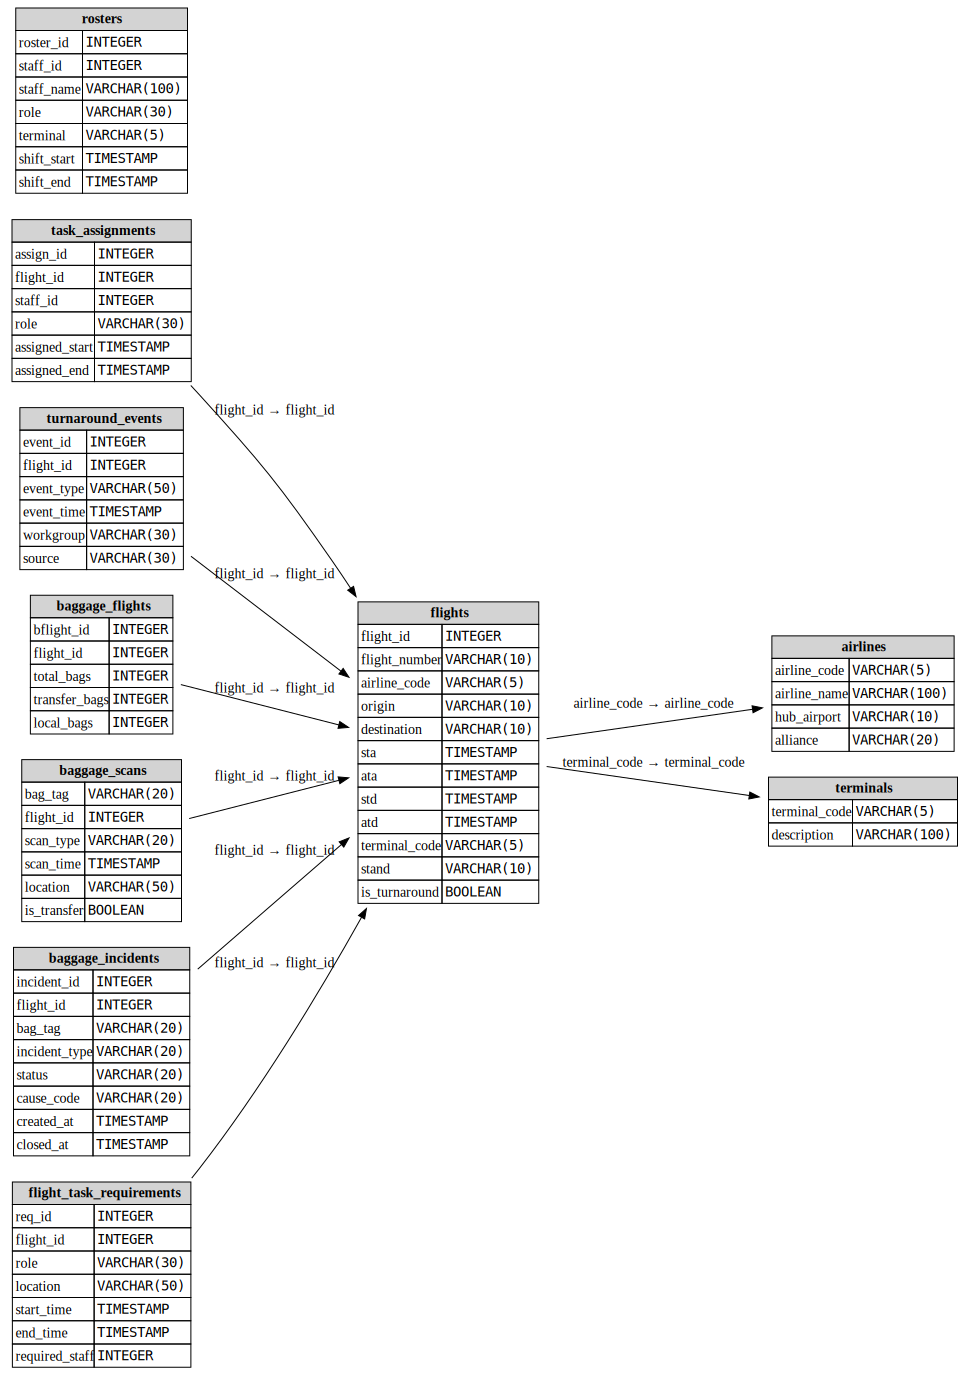

In [52]:
public_erd = make_erd_for_schema(
    engine,
    "public",
    only_tables=[
        "airlines",
        "terminals",
        "flights",
        "turnaround_events",
        "baggage_flights",
        "baggage_scans",
        "baggage_incidents",
        "rosters",
        "flight_task_requirements",
        "task_assignments",
    ],
)

public_erd  # akan render SVG langsung di notebook




In [53]:
public_erd.render("docs/schema_public", format="png", cleanup=True)

'docs/schema_public.png'

In [54]:
import os
from IPython.display import display

def render_schema_erd(engine, schema_name, only_tables, out_basename):
    """
    - engine      : SQLAlchemy engine
    - schema_name : nama schema ('public', 'dxb_ops', 'eng_proc', ...)
    - only_tables : list nama tabel yang mau digambar (boleh None)
    - out_basename: nama dasar file (tanpa extension), misal 'schema_public'
    """
    erd = make_erd_for_schema(engine, schema_name, only_tables=only_tables)
    
    # tampilkan di notebook (kalau dot sudah jalan)
    display(erd)
    
    # pastikan folder docs ada
    os.makedirs("docs", exist_ok=True)
    
    # simpan ke docs/<out_basename>.png
    out_path = erd.render(
        filename=out_basename,
        directory="docs",
        format="png",
        cleanup=True,
    )
    print(f"Nodes: {len(erd.body)} (lihat visualnya di file)")
    print(f"Diagram disimpan ke: {out_path}")
    return erd


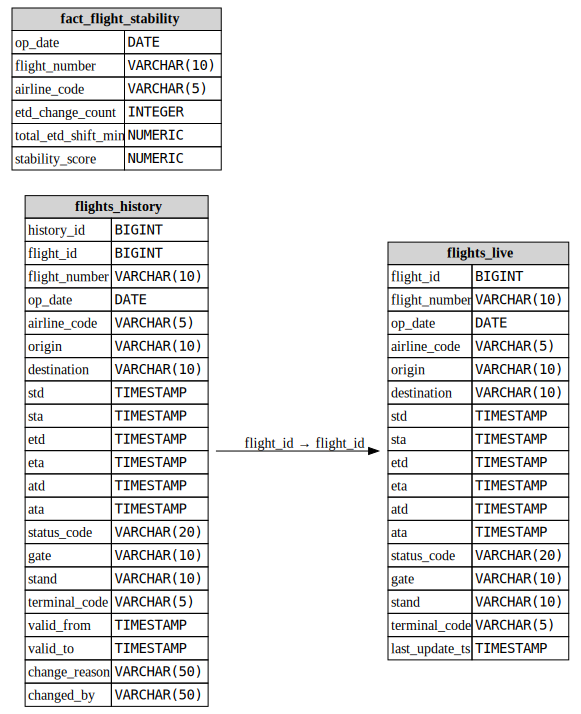

Nodes: 6 (lihat visualnya di file)
Diagram disimpan ke: docs/schema_dxb_ops_flight_stability.png


In [55]:
dxb_ops_erd = render_schema_erd(
    engine,
    schema_name="dxb_ops",
    only_tables=[
        "flights_live",
        "flights_history",
        "fact_flight_stability",
    ],
    out_basename="schema_dxb_ops_flight_stability"  # → docs/schema_dxb_ops_flight_stability.png
)


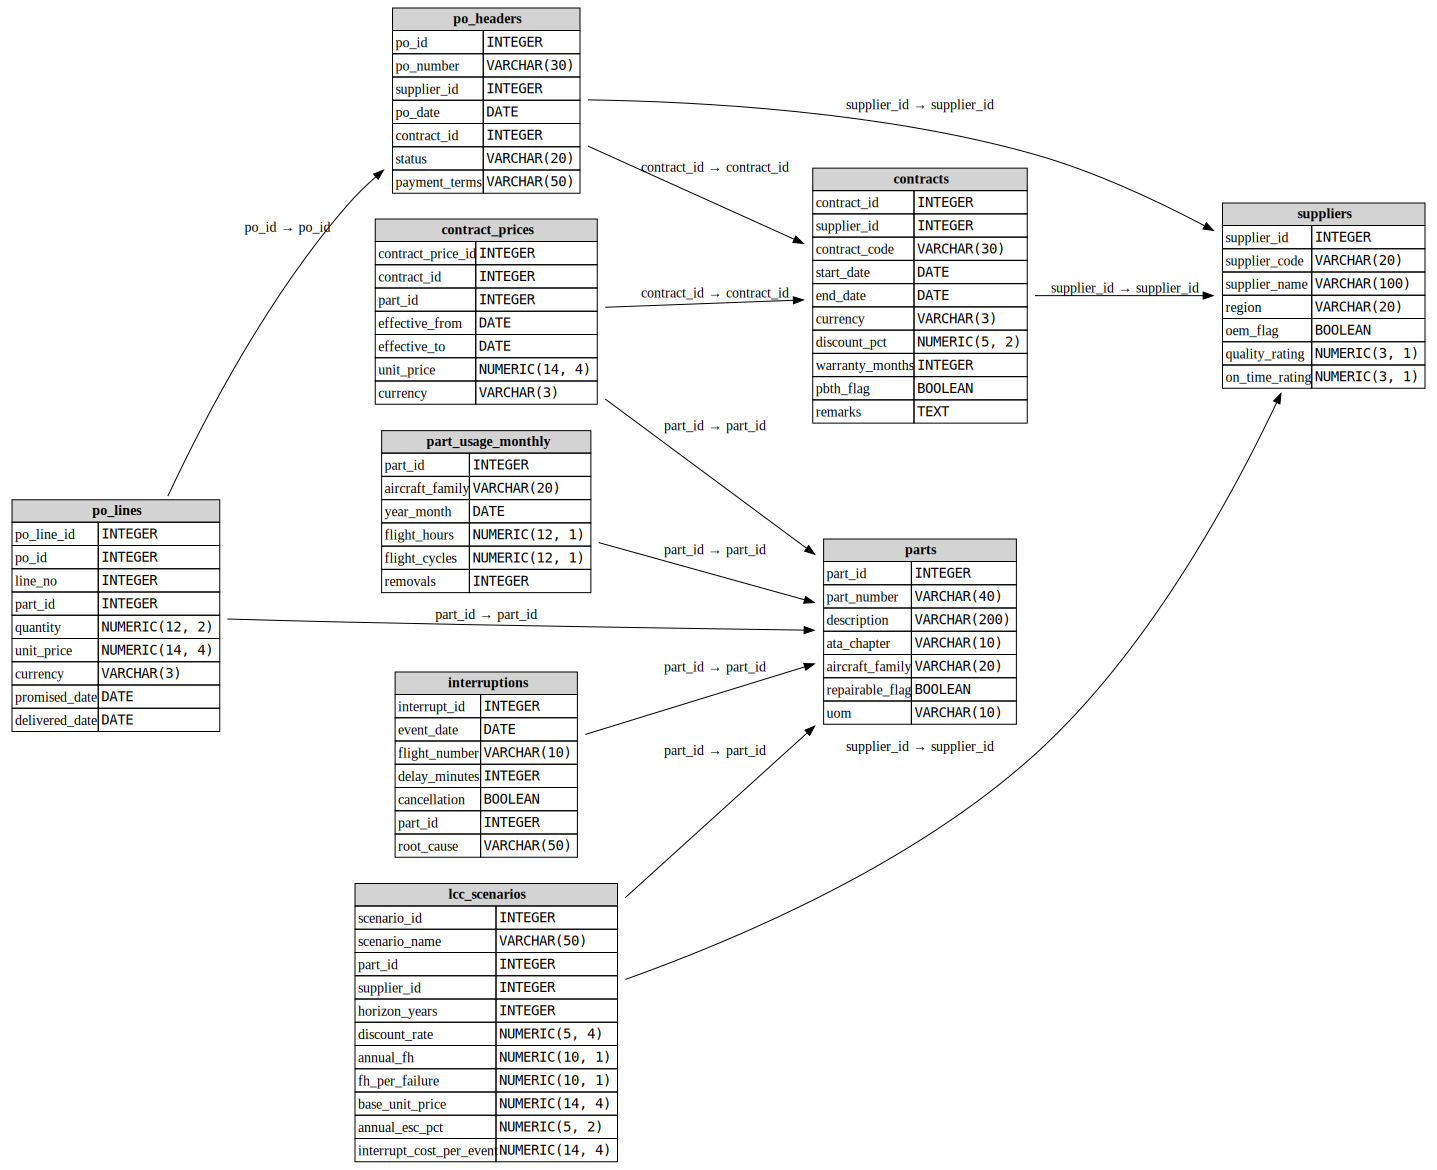

Nodes: 22 (lihat visualnya di file)
Diagram disimpan ke: docs/schema_eng_proc_lcc.png


In [56]:
eng_proc_erd = render_schema_erd(
    engine,
    schema_name="eng_proc",
    only_tables=[
        "suppliers",
        "parts",
        "contracts",
        "contract_prices",
        "po_headers",
        "po_lines",
        "part_usage_monthly",
        "interruptions",
        "lcc_scenarios",
    ],
    out_basename="schema_eng_proc_lcc"  # → docs/schema_eng_proc_lcc.png
)


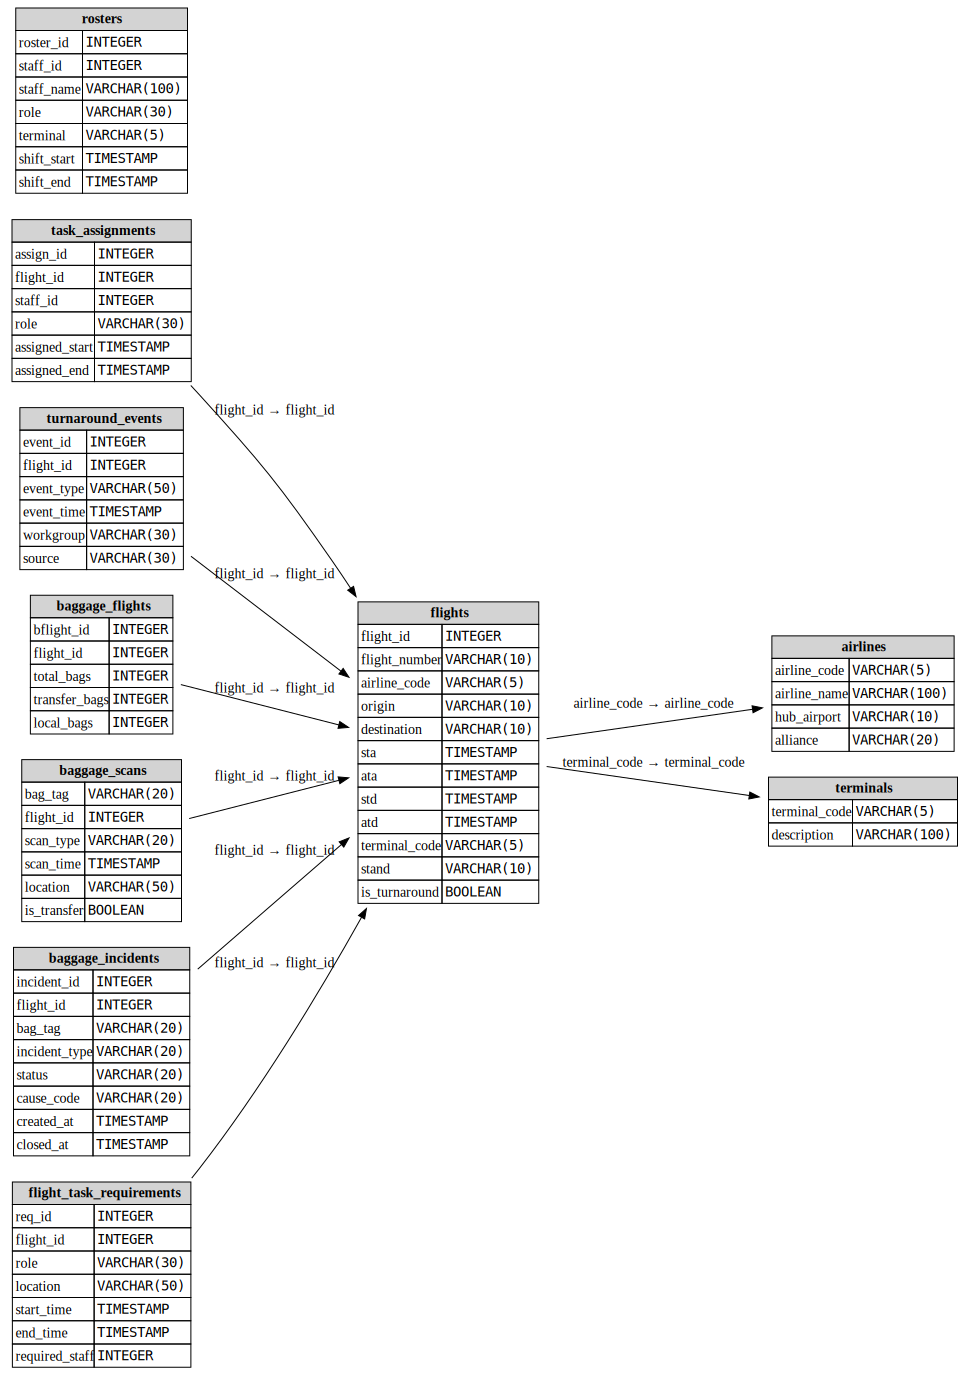

Nodes: 20 (lihat visualnya di file)
Diagram disimpan ke: docs/schema_public_python.png


In [58]:
public_erd = render_schema_erd(
    engine,
    schema_name="public",
    only_tables=[
        "airlines",
        "terminals",
        "flights",
        "turnaround_events",
        "baggage_flights",
        "baggage_scans",
        "baggage_incidents",
        "rosters",
        "flight_task_requirements",
        "task_assignments",
    ],
    out_basename="schema_public_python"  # → docs/schema_public_python.png
)
